# Financial Sentiment Analysis
In this notebook I did Financial Sentiment Analysis by using different models
- First, Classification Models: Naive Bayes Classification Model
- Then, Sequential Models: RNN, LSTM, GRU
- Finally, Transformers: Bert

By the end of the notebook there's a comparison between results of each model

In [2]:
# Essentials
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Import functions for data preprocessing & data preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation
import nltk
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/financial-sentiment-analysis/data.csv


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1) Reading Data

In [4]:
data = pd.read_csv("../input/financial-sentiment-analysis/data.csv")
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


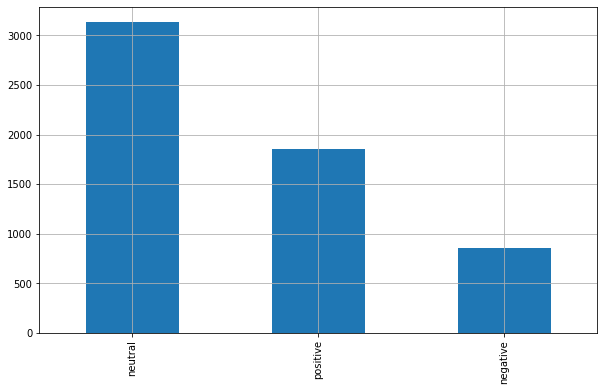

In [5]:
data['Sentiment'].value_counts().plot(kind='bar',figsize=(10,6),grid='-')
plt.show()

In [6]:
data['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

> It seems that data is not balanced

## 2) Preprocessing

### 2.1) Data Cleaning

In [7]:
stop_words = stopwords.words('english')
porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer() 
snowball_stemer = SnowballStemmer(language="english")
lzr = WordNetLemmatizer()

In [8]:
def text_processing(text):   
    # convert text into lowercase
    text = text.lower()

    # remove new line characters in text
    text = re.sub(r'\n',' ', text)
    
    # remove punctuations from text
    text = re.sub('[%s]' % re.escape(punctuation), "", text)
    
    # remove references and hashtags from text
    text = re.sub("^a-zA-Z0-9$,.", "", text)
    
    # remove multiple spaces from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove special characters from text
    text = re.sub(r'\W', ' ', text)
    
    # tokenize the words using nltk word tokenizer and remove the stop words using nltk package's english stop words
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    
    # stemming using porter stemmer from nltk package - msh a7sn 7aga - momken: lancaster, snowball
    # text=' '.join([porter_stemmer.stem(word) for word in word_tokenize(text)])
    # text=' '.join([lancaster_stemmer.stem(word) for word in word_tokenize(text)])
    # text=' '.join([snowball_stemer.stem(word) for word in word_tokenize(text)])
    
    # lemmatizer using WordNetLemmatizer from nltk package
    text=' '.join([lzr.lemmatize(word) for word in word_tokenize(text)])

    return text

In [9]:
data_copy = data.copy()
data_copy.Sentence = data_copy.Sentence.apply(lambda text: text_processing(text))

In [10]:
le = LabelEncoder()
data_copy['Sentiment'] = le.fit_transform(data_copy['Sentiment'])

In [11]:
processed_data = {
    'Sentence':data_copy.Sentence,
    'Sentiment':data_copy['Sentiment']
}

processed_data = pd.DataFrame(processed_data)
processed_data.head()

,Sentence,Sentiment
0,geosolutions technology leverage benefon gps s...,2
1,esi low 150 250 bk real possibility,0
2,last quarter 2010 componenta net sale doubled ...,2
3,according finnishrussian chamber commerce majo...,1
4,swedish buyout firm sold remaining 224 percent...,1


In [19]:
processed_data['Sentiment'].value_counts()

1    3130
2    1852
0     860
Name: Sentiment, dtype: int64

### 2.2) Data Resampling
Since, Data is not balanced we need to do resampling to get balanced data

In [21]:
df_neutral = processed_data[(processed_data['Sentiment']==1)] 
df_negative = processed_data[(processed_data['Sentiment']==0)]
df_positive = processed_data[(processed_data['Sentiment']==2)]

# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples= 3130, 
                                 random_state=42)  

df_positive_upsampled = resample(df_positive, 
                                 replace=True,    
                                 n_samples= 3130, 
                                 random_state=42)  


# Concatenate the upsampled dataframes with the neutral dataframe
final_data = pd.concat([df_negative_upsampled,df_neutral,df_positive_upsampled])

In [23]:
final_data['Sentiment'].value_counts()

0    3130
1    3130
2    3130
Name: Sentiment, dtype: int64

## 3. Classification with Classifier Model (Naive Bayes)

### 3.1) Data Transformation

In [156]:
corpus = []
for sentence in final_data['Sentence']:
    corpus.append(sentence)
corpus[0:5]

['currency effect 30 pct 20 mln euro 313 mln negative impact revenue',
 'mflx pre mkt look like gap filledlookin 4 short opt',
 'however growth margin slowed due financial crisis',
 'bad idea make 5 min prediction based faith rt dandyduct aapl sell signal hit 584 go next 5 min',
 'key price watch nflx previous double top reject 21823 httpstkscosiyn']

In [157]:
from sklearn.feature_extraction.text import CountVectorizer

In [158]:
cv = CountVectorizer(max_features=1500)

In [159]:
X = cv.fit_transform(corpus).toarray()
y = final_data.iloc[:, -1].values

### 3.2) Dividing data into train and test

In [160]:
from sklearn.model_selection import train_test_split

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 3.3) Model fitting

In [162]:
from sklearn.naive_bayes import GaussianNB

In [163]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

### 3.4) Model Evaluation

In [164]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)

In [165]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[891,  24,  25],
       [400, 398, 151],
       [386,  84, 458]])

In [166]:
nb_score = accuracy_score(y_test, y_pred)
nb_score

0.6201632942847001

## 4) RNN, LSTM, GRU

In [139]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer

### 4.1) Data Preparation

In [140]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [141]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(final_data['Sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11161 unique tokens.


In [142]:
X_final = tokenizer.texts_to_sequences(final_data['Sentence'].values)
X_final = pad_sequences(X_final, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_final.shape)

Shape of data tensor: (9390, 250)


In [143]:
Y_final = pd.get_dummies(final_data['Sentiment']).values
print('Shape of label tensor:', Y_final.shape)

Shape of label tensor: (9390, 3)


### 4.2) Dividing data into train and test

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size = 0.3, random_state = 42, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6573, 250) (6573, 3)
(2817, 250) (2817, 3)


### 4.3) Model Training

#### 4.3.1) RNN

In [150]:
rnn_model = Sequential()
rnn_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_final.shape[1]))
rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(3, activation='softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

rnn_history = rnn_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 37s 429ms/step - loss: 1.1295 - accuracy: 0.3657 - val_loss: 1.0452 - val_accuracy: 0.3878
Epoch 2/5
83/83 [==============================] - 35s 417ms/step - loss: 0.9871 - accuracy: 0.5253 - val_loss: 0.8849 - val_accuracy: 0.6669
Epoch 3/5
83/83 [==============================] - 34s 412ms/step - loss: 0.7460 - accuracy: 0.7088 - val_loss: 0.7319 - val_accuracy: 0.7027
Epoch 4/5
83/83 [==============================] - 34s 416ms/step - loss: 0.4935 - accuracy: 0.8260 - val_loss: 0.6103 - val_accuracy: 0.7688
Epoch 5/5
83/83 [==============================] - 34s 415ms/step - loss: 0.3307 - accuracy: 0.8779 - val_loss: 0.5964 - val_accuracy: 0.7878


#### 4.3.1) LSTM

In [151]:
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_final.shape[1]))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

lstm_history = lstm_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 105s 1s/step - loss: 0.9999 - accuracy: 0.5027 - val_loss: 0.8060 - val_accuracy: 0.6783
Epoch 2/5
83/83 [==============================] - 103s 1s/step - loss: 0.5855 - accuracy: 0.7910 - val_loss: 0.6197 - val_accuracy: 0.7764
Epoch 3/5
83/83 [==============================] - 101s 1s/step - loss: 0.3121 - accuracy: 0.8887 - val_loss: 0.5515 - val_accuracy: 0.8167
Epoch 4/5
83/83 [==============================] - 104s 1s/step - loss: 0.2076 - accuracy: 0.9213 - val_loss: 0.5661 - val_accuracy: 0.8205
Epoch 5/5
83/83 [==============================] - 103s 1s/step - loss: 0.1688 - accuracy: 0.9306 - val_loss: 0.6271 - val_accuracy: 0.8114


#### 4.3.1) GRU

In [152]:
gru_model = Sequential()
gru_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_final.shape[1]))
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(3, activation='softmax'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

gru_history = gru_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 95s 1s/step - loss: 0.9959 - accuracy: 0.5070 - val_loss: 0.8017 - val_accuracy: 0.6175
Epoch 2/5
83/83 [==============================] - 91s 1s/step - loss: 0.5419 - accuracy: 0.7872 - val_loss: 0.6006 - val_accuracy: 0.7840
Epoch 3/5
83/83 [==============================] - 92s 1s/step - loss: 0.2749 - accuracy: 0.8939 - val_loss: 0.5755 - val_accuracy: 0.7954
Epoch 4/5
83/83 [==============================] - 92s 1s/step - loss: 0.2004 - accuracy: 0.9216 - val_loss: 0.6790 - val_accuracy: 0.8023
Epoch 5/5
83/83 [==============================] - 92s 1s/step - loss: 0.1670 - accuracy: 0.9317 - val_loss: 0.6665 - val_accuracy: 0.8190


### 4.4) Model Evaluation

In [153]:
rnn_accuracy = rnn_model.evaluate(X_test,Y_test)
print('RNN Model Evaluation\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(rnn_accuracy[0],rnn_accuracy[1]))

89/89 [==============================] - 2s 23ms/step - loss: 0.5958 - accuracy: 0.7696
RNN Model Evaluation
 Loss: 0.596
 Accuracy: 0.770


In [154]:
lstm_accuracy = lstm_model.evaluate(X_test,Y_test)
print('LSTM Model Evaluation\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(lstm_accuracy[0],lstm_accuracy[1]))

89/89 [==============================] - 6s 72ms/step - loss: 0.6516 - accuracy: 0.7977
LSTM Model Evaluation
 Loss: 0.652
 Accuracy: 0.798


In [155]:
gru_accuracy = gru_model.evaluate(X_test,Y_test)
print('GRU Model Evaluation\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(gru_accuracy[0],gru_accuracy[1]))

89/89 [==============================] - 6s 70ms/step - loss: 0.6731 - accuracy: 0.8062
GRU Model Evaluation
 Loss: 0.673
 Accuracy: 0.806


#### 4.5) Plotting Results

In [ ]:
# def get_plot(trained_model):
#     accuracy=trained_model.history['accuracy']
#     loss=trained_model.history['loss']
#     val_accuracy=trained_model.history['val_accuracy']
#     val_loss=trained_model.history['val_loss']
#     epochs=[i for i in range(1,6)]

#     plt.figure(figsize=(12,8))
#     plt.plot(epochs,accuracy,'r',label='Training')
#     plt.plot(epochs,val_accuracy,'--',label='Validation')
#     plt.legend()
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy',fontsize=15)
#     plt.grid()
#     plt.show()

#     plt.figure(figsize=(12,8))
#     plt.plot(epochs,loss,'r',label='Training')
#     plt.plot(epochs,val_loss,'--',label='Validation')
#     plt.legend()
#     plt.title('Loss',fontsize=15)
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.grid()
#     plt.show()

## BERT

In [24]:
from transformers import AutoTokenizer, TFBertModel

bert_tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
bert_model = TFBertModel.from_pretrained("bert-large-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

2022-07-05 00:04:16.167832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 00:04:16.169148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 00:04:16.169953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 00:04:16.170978: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [97]:
print("Max length of Sentences:", max([len(x.split()) for x in final_data['Sentence']]))
print("Min length of Sentences:", min([len(x.split()) for x in final_data['Sentence']]))

Max length of Sentences: 47
Min length of Sentences: 0


In [98]:
from sklearn.model_selection import train_test_split
X_train_bert, X_test_bert, Y_train_bert, Y_test_bert = train_test_split(final_data['Sentence'], final_data['Sentiment'], test_size = 0.25, random_state = 0, shuffle=True)
print(X_train_bert.shape,Y_train_bert.shape)
print(X_test_bert.shape,Y_test_bert.shape)

(7042,) (7042,)
(2348,) (2348,)


In [125]:
X_bert_train_final = bert_tokenizer(
    text=X_train_bert.tolist(),
    add_special_tokens=True,
    max_length=50,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_bert_train_final['input_ids'].shape

TensorShape([7042, 50])

In [126]:
X_bert_train_final.keys()

dict_keys(['input_ids', 'attention_mask'])

In [127]:
Y_bert_test_final = pd.get_dummies(Y_test_bert).values
Y_bert_train_final = pd.get_dummies(Y_train_bert).values
Y_bert_train_final.shape, Y_bert_test_final.shape

((7042, 3), (2348, 3))

In [128]:
Y_train_bert.value_counts()

2    2367
1    2338
0    2337
Name: Sentiment, dtype: int64

### 5.2) Build Model

In [129]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import tensorflow_hub as hub

In [130]:
MAX_LENGTH = 50
INPUT_IDs = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids")
INPUT_MASK = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_mask")

In [134]:
embeddings = bert_model([INPUT_IDs, INPUT_MASK])[1] # 0 is hidden state, 1 is pooler_output
# shape of hidden state is (None, MAX_LENGTH, 1024) ==> out = tf.keras.layers.GlobalMaxPool1D(0.1)(embeddings)
# shape of booled output is (None, 1024) ==> out = tf.keras.layers.Dropout(0.1)(embeddings)

out = tf.keras.layers.Dropout(0.2)(embeddings)
out = Dense(64, activation="relu")(out)
out = tf.keras.layers.Dropout(0.2)(out)
out = Dense(32, activation="relu")(out)

y = Dense(3, activation='softmax')(out)
model = tf.keras.Model(inputs=[INPUT_IDs, INPUT_MASK], outputs=y)
model.layers[2].trainable = True

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     multiple             335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_98 (Dropout)            (None, 1024)         0           tf_bert_model[15][1]      

In [136]:
# fit model
bert_history = model.fit(
    x={'input_ids': X_bert_train_final["input_ids"], 'attention_mask': X_bert_train_final["attention_mask"]},
    y=Y_bert_train_final,
    validation_split=0.15,
    epochs=5,
    batch_size=24
)

Epoch 1/5
250/250 [==============================] - 167s 544ms/step - loss: 1.1266 - accuracy: 0.3347 - val_loss: 1.1032 - val_accuracy: 0.3245
Epoch 2/5
250/250 [==============================] - 133s 531ms/step - loss: 1.0987 - accuracy: 0.3347 - val_loss: 1.0985 - val_accuracy: 0.3463
Epoch 3/5
250/250 [==============================] - 132s 527ms/step - loss: 1.0988 - accuracy: 0.3285 - val_loss: 1.0987 - val_accuracy: 0.3292
Epoch 4/5
250/250 [==============================] - 131s 524ms/step - loss: 1.0987 - accuracy: 0.3373 - val_loss: 1.0988 - val_accuracy: 0.3292
Epoch 5/5
250/250 [==============================] - 131s 523ms/step - loss: 1.0991 - accuracy: 0.3405 - val_loss: 1.0991 - val_accuracy: 0.3292


In [137]:
X_test_bert_final = bert_tokenizer(
    text=X_test_bert.tolist(),
    add_special_tokens=True,
    max_length=50,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [138]:
prediction = model.predict(
    x={'input_ids':X_test_bert_final["input_ids"], 'attention_mask':X_test_bert_final["attention_mask"]}
)

In [143]:
prediction.shape

(2817, 3)

In [163]:
y_pred = []
for i in range(len(prediction)):
    y_pred.append(tf.one_hot(tf.argmax(prediction[i]), 3)) 
y_pred = np.array(y_pred)

In [164]:
y_pred[:3]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [161]:
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy_score(Y_bert_test_final, y_pred)

0.32658856940007097

## Conclusion

In [172]:
nb_acc = nb_score * 100
rnn_acc = rnn_accuracy[1] * 100
lstm_acc = lstm_accuracy[1] * 100
gru_acc = gru_accuracy[1] * 100

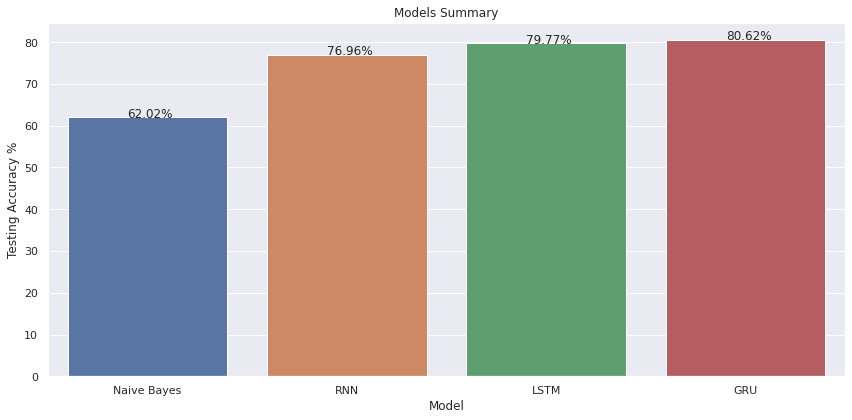

In [176]:
import seaborn as sns
methods = ["Naive Bayes","RNN", "LSTM", "GRU"]
accuracy = [nb_acc, rnn_acc, lstm_acc, gru_acc]

sns.set()
plt.figure(figsize=(12,6))
plt.title("Models Summary")
plt.ylabel("Testing Accuracy %")
plt.xlabel("Model")
sns.barplot(x=methods, y=accuracy, palette="deep")

for idx, method in enumerate(methods):
    plt.text(idx -0.1, accuracy[idx]+0.02, "{:.2f}%".format(accuracy[idx]))
    
plt.tight_layout()

> As shown, GRU and LSTM got the highest accuracy score